In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as op
from cvxopt import solvers
from cvxopt import matrix

In [5]:
def project(y, A):
    n = y.size

    P = matrix(A, tc='d')
    q = matrix(-2*np.matmul(y, A), tc='d')
    G = matrix(-np.eye(n), tc='d')
    h = matrix(np.zeros(n), tc='d')
    A = matrix(np.ones([1,n]), tc='d')
    b = matrix([1], tc='d')
    
    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h,A,b)
    return np.array(sol['x']).reshape(-1)

In [6]:
# Data
n = 10
T = 4000

r = 1 + 0.01*np.random.randn(n,T) + 0.001*np.random.randn(n,1) 
stocks =  np.cumprod(r, axis = 1) 

In [7]:
# Parameters
alpha = 0.9/np.sqrt(n)
G = np.sqrt(n)/alpha
gamma = 1/8/G
epsilon = 1/gamma**2

# Initialization
A = epsilon*np.eye(n)
x = np.ones(n)/n
f = np.zeros(T)

# Algorithms
for t in range(T-1):
    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = - r/np.dot(x, r)

    # ONS
    A = A + np.outer(grad, grad)
    y = x - 1/gamma * np.linalg.solve(A, grad)
    x = project(y, A)

wealth1 = np.cumsum(-f)

In [8]:
# parameter free expert
sum_g_tild = np.zeros(n)
sum_g_w = np.zeros(n)
x_0 = np.ones(n)/n
for t in range(T-1):

    w = sum_g_tild /(t+T/2)*(1+sum_g_w)
    x = x_0 * np.maximum(w, 0)

    if np.sum(x) > 0:
        x = x / np.sum(x)
    else:
        x = x_0

    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = r/np.dot(x, r)

    g_tild = grad - np.dot(grad, x)
    g_tild[w<0] = np.maximum(g_tild[w<0], 0)

    sum_g_tild += g_tild
    sum_g_w += g_tild

wealth2 = np.cumsum(-f)

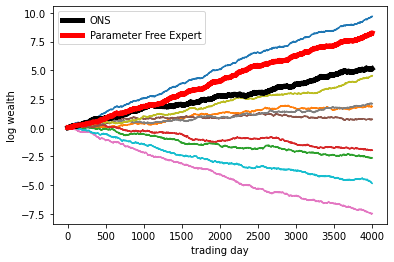

In [9]:
# Visualization
fig, ax = plt.subplots()

for s in range(n):
    ax.plot(np.arange(T),np.log(stocks[s]))

ax.plot(np.arange(T), wealth1, 'k' , linewidth=5, label='ONS')
ax.plot(np.arange(T), wealth2, 'r' , linewidth=5, label='Parameter Free Expert')
ax.legend()
ax.set_xlabel('trading day')
ax.set_ylabel('log wealth')
plt.show()